# Capstone exploration


## Ideas not implimented

- Add position as a feature
- Color the spoke type wrinkles and dense wrinkles as two seperate classes
- Run this model on video so you can play a video of the wrinkle only
- Could plot % wrinkle by type over time.
- Calculate distribution of how close wrinkles are to center


In [10]:
# Additional python packages
import os, urllib, io, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
import scipy.misc

from functions import * # Our functions

init_notebook_mode(connected=True)

## Work with scanner images

#### Load images and meta data

In [117]:

images = []
names  = []
for root, dirs, files in os.walk('../final_dataset'):
    for name in files:
        mypath = os.path.join(root,name)
        img    = Image.open(mypath, mode='r')
        img    = img.resize((128,128))
        arr    = np.array(img).astype('uint8')
        images.append(arr)
        img.close()
        names.append(name.split('.')[0])

gene=[name.split('_')[0] for name in names]
days=[int(name.split('_')[1]) for name in names]
biofilm_number=[name.split('_')[2] for name in names]
dic={'label':names,'gene':gene,'days':days,'biofilm_number':biofilm_number}

df_all=pd.DataFrame.from_dict(dic)


In [125]:
 # Sort values by unique biofilm
df_all = df_all.sort_values(by=['biofilm_number', 'gene', 'days'])
images = [images[i] for i in df_all.index.values.tolist()]
df_all = df_all.reset_index()

#### Lets look at some of the images

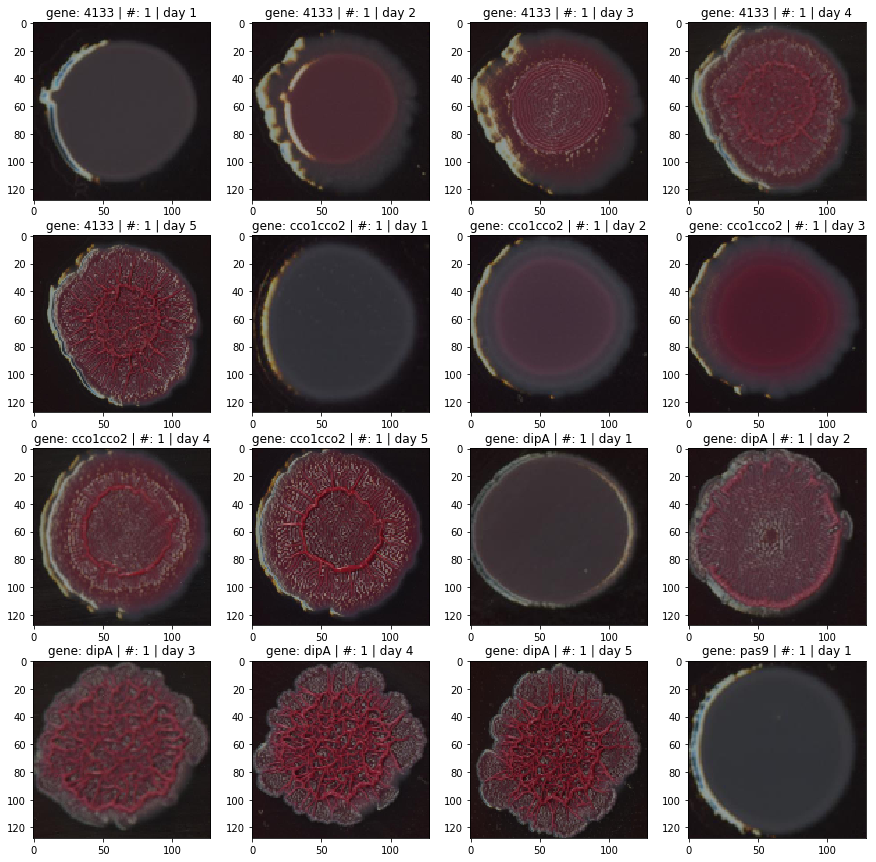

In [151]:
fig = plt.figure(figsize=(15,15))
n   = 4

for i,s in enumerate(images):
    try:
        fig.add_subplot(n,n,i+1)
        plt.imshow(s)
        title = 'gene: %s | #: %s | day %d' %(df_all['gene'][i], df_all['biofilm_number'][i], df_all['days'][i])
        plt.title(title)
    except:
        pass
    
plt.show()

#### Process Images to find Wrinkles

In [173]:
def bf_size(image):
    a      = image.max(axis=2)
    tmp    = a > 30
    tmp_im = a * tmp
    return int(np.count_nonzero(tmp_im))
# def bf_size_vis(image):
#     a = image.max(axis=2)
#     tmp = a > 30
#     return a * tmp
def perc_wrinkled(img, biofilm_size):
    img[np.isnan(img)] = 0
    return round(np.sum(img)/biofilm_size, 4)

In [174]:
processed_images     = [get_classes(img,threshold_val=0, resize=128, n_clusters=2)[1] for img in images]
bfsizes              = [bf_size(img) for img in images]
df_all['bf_size']    = bfsizes
perc_wrink           = [perc_wrinkled(img, bfsizes[i]) for i, img in enumerate(processed_images)]
df_all['perc_wrink'] = perc_wrink

#### Plots of processed images

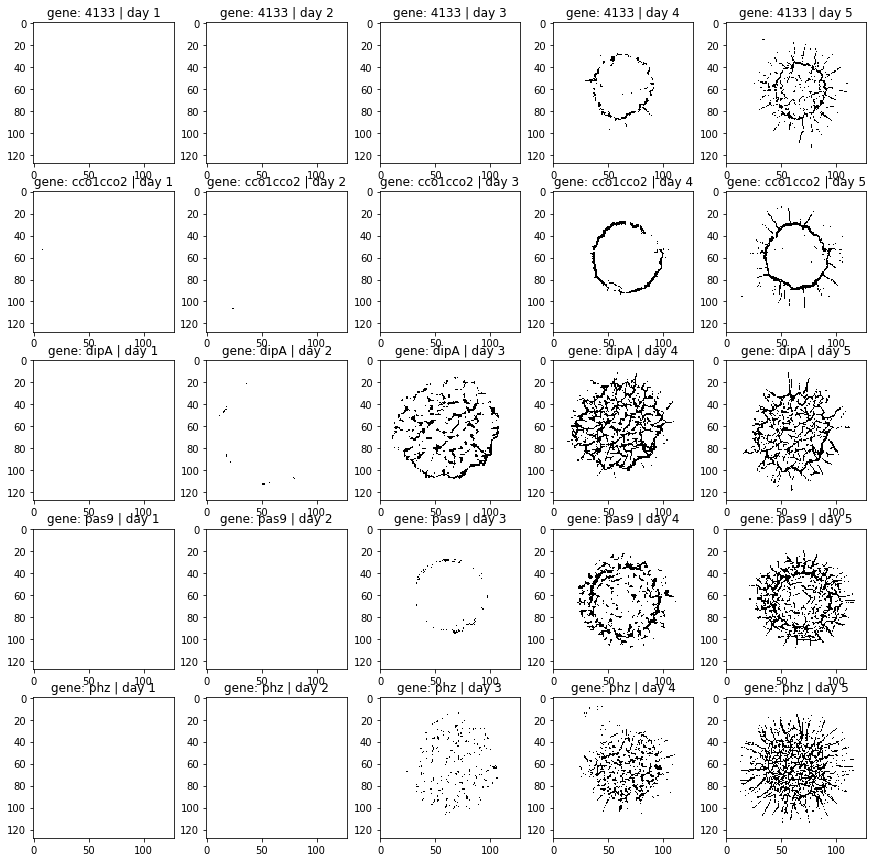

In [175]:
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(15,15))

n = 5

for i,s in enumerate(processed_images):
    try:
        fig.add_subplot(n,n,i+1)
        plt.imshow(s, cmap='binary')
        title =  'gene: %s | day %d' %(df_all['gene'][i],df_all['days'][i])# '%s | %d | %f ' %(df_all['gene'][i],df_all['bf_size'][i],df_all['perc_wrink'][i])
        plt.title(title)
    except:
        pass
plt.show()

### Plot scanner images

#### Percent wrinkle over time by gene

In [228]:
df    = df_all.groupby(['gene', 'days'], as_index=False).mean()
genes = df[df['days'] == 5].sort_values(by=['perc_wrink'])['gene']
data  = []
for gene in genes:
    trace = go.Scatter(
        x=df['days'][df['gene'] == gene],
        y=df['perc_wrink'][df['gene'] == gene],
        mode='lines+markers',
        name=gene
    )
    data.append(trace)
#     break

# Edit the layout
layout = dict(title = 'Percent Wrinkle Over Time',
              xaxis = dict(title = 'Days'),
              yaxis = dict(title = 'Percent wrinkle (%)'),
              )


fig = go.Figure(data=data, layout=layout)

iplot(fig)

#### Percent Wrinkle by Gene on Day Five

9     cco1cco2
29        rmcA
4         4133
34          wt
24         phz
19        pas9
14        dipA
Name: gene, dtype: object

In [227]:
data  = []
day   = 5
df    = df_all.groupby(['gene', 'days'], as_index=False).mean()
genes = df[df['days'] == 5].sort_values(by=['perc_wrink'])['gene']
for gene in genes:
    trace = go.Box(
        y=df_all['perc_wrink'][(df_all['gene'] == gene) & (df_all['days'] == day)],
        boxpoints = 'all',
        name=gene
    )
    data.append(trace)

# Edit the layout
layout = dict(title = 'Percent Wrinkle by Gene on Day Five',
              yaxis = dict(title = 'Percent wrinkle (%)'),
              )


fig = go.Figure(data=data, layout=layout)

iplot(fig)

## Keyance image analysis

In [2]:
images = load_images('/home/isaac/Documents/capstone_pics/Keyence', size=(128,128))
images = np.array(images)

We started with the examplype K? type picture below as it provided a good example for determine the percent wrinkle. To clarify for those not in the field, like us, the wrinkle is the red strings in the middle.

### Plot images

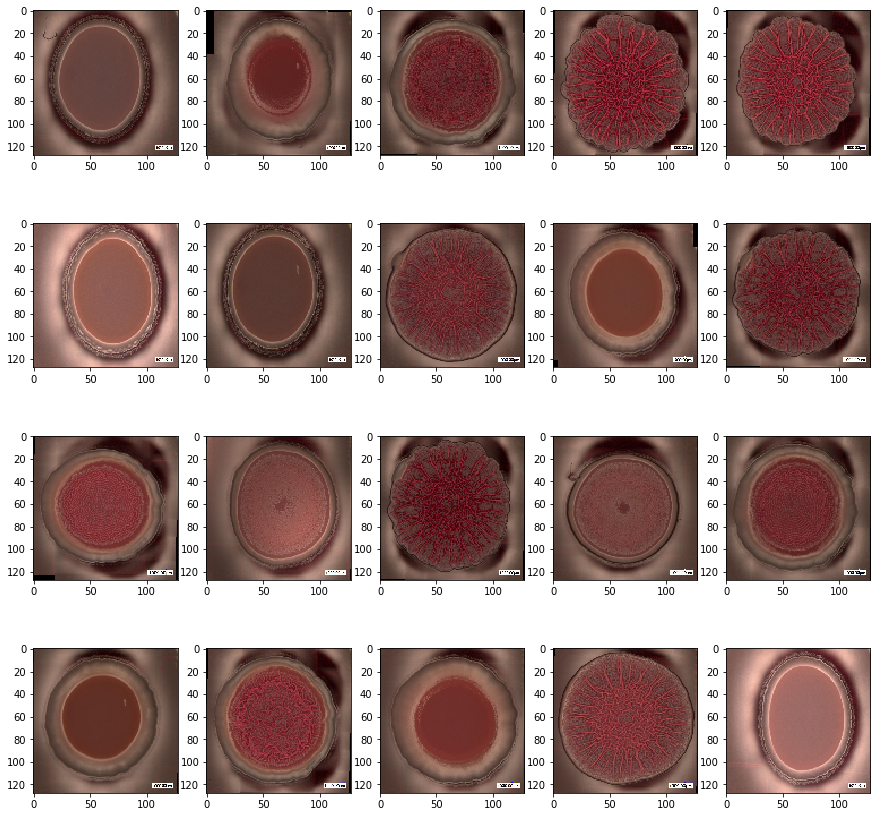

In [6]:
f, axarr = plt.subplots(4,5,figsize=(15,15))
k=0
for i in range(4):
    for j in range(5):
        axarr[i,j].imshow(images[k])
        k+=1

plt.savefig('multiple_images.png')

In [14]:
def get_wrinkle_class_old(img, resize=128,n_clusters=6, threshold_val=100):
    labels    = get_classes(img, resize=resize, n_clusters=n_clusters, movie=False, threshold_val=threshold_val)[0]
    img_array = np.asarray(img)
    img_array = img_array[:,:,:3]
    w,h,d     = tuple(img_array.shape)
    X         = np.reshape(img_array, (w*h,d))
    df        = pd.DataFrame(X, columns=['red', 'green', 'blue'])
    df_mean   = df.astype('int').groupby(labels).mean()

    # Find most red class
    df_mean['red_diff'] = df_mean['red'] - df_mean['green'] - df_mean['blue']
    wrinkle_id     = np.argmax(df_mean['red_diff'])
    wrinkle_labels      = [1 if i == wrinkle_id else 0 for i in labels]

    # Plot
    wrinkle_classes     = np.reshape(wrinkle_labels, img_array.shape[:2]) 
    wrinkle_classes     = np.multiply(wrinkle_classes, 255.0/np.max(wrinkle_classes))

    return(wrinkle_labels,wrinkle_classes)

/home/isaac/anaconda2/envs/tf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning:

'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.



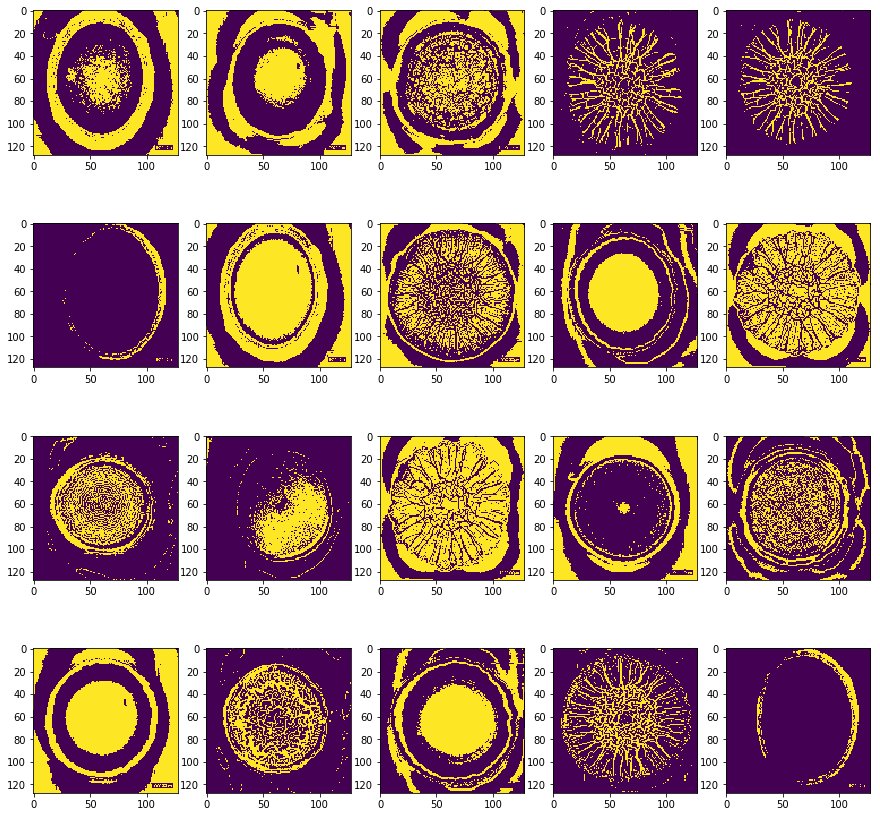

In [15]:
img_classes=[get_wrinkle_class_old(img, resize=128, n_clusters=6)[1] for img in images]

f, axarr = plt.subplots(4,5 ,figsize=(15,15))
k=0
for i in range(4):
    for j in range(5):
        axarr[i,j].imshow(img_classes[k])
        k += 1
        
plt.savefig('wrinkle_class_multiple_old.png')

In [42]:
def get_classes(img, resize=128, n_clusters=6, movie=False,threshold_val=100):
    
    """
    img: initial image

    returns: the labels of the pixels and the image colored by the classes
    """
    # convert into image if is array
    try:
        img = Image.fromarray(img, 'RGB')
    except:
        pass
    
    # keeps pixels above threshold
    img = threshold_image(img, threshold_val)
    
    # Resize
    if not movie:
        size=(resize, resize)
        img_resize       = img.resize(size, Image.ANTIALIAS)#resize
        img_array_resize = np.asarray(img_resize)
    else:
        reduce_factor    = 4
        size             = tuple(np.divide(img.shape[:2], reduce_factor).astype(int)) + (3,)
        img_array_resize = np.resize(img, size)


    # Reshape
    w,h,d = tuple(img_array_resize.shape)
    X     = np.reshape(img_array_resize, (w*h,d))

    # Add differences and ratios to red as features
#     a = X[:,0] / (X[:,0] + X[:,2])
#     a[np.isnan(a)] = 0
#     a = np.reshape(a, (resize**2, 1))
#     X = np.append(X, a, axis=1)

#     b = X[:,0] / (X[:,0] + X[:,1])
#     b[np.isnan(b)] = 0
#     b = np.reshape(b, (resize**2, 1))
#     X = np.append(X, b, axis=1)
    
#     c = X[:,0] - X[:,1] + X[:,2]
#     c[np.isnan(c)] = 0
#     c = np.reshape(c, (resize**2, 1))
#     X = np.append(X, c, axis=1)
    
    # Add radial distance as feature
    y_axis = np.array([])
    for i in np.arange(resize):
        y_axis = np.append(y_axis, np.arange(resize))
        
    y_axis          = np.reshape(y_axis, (resize**2, 1))
    x_axis          = np.reshape(np.repeat(np.arange(resize), resize), (resize**2, 1))
    radial_distance = np.sqrt(np.abs(x_axis - (resize / 2))**2 + np.abs(y_axis - (resize / 2))**2)
    X               = np.append(X, radial_distance, axis=1)

    # Remove blue and green
#     X = X[:,[0, 3, 4, 5]]
#     X = X[:,3:]

    
    # Fit model
#     km    = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
#     km = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
    
    # Determine labels and classes
    img_array = np.asarray(img)
    w,h,d     = tuple(img_array.shape)
    labels    = [((X[:,0] > 100) * 1) & np.abs((1 - (X[:,1] / X[:,2])) < 0.75)
                & (X[:,1] < 80) & (X[:,2] < 80) & ((X[:,0]/ (X[:,1] + X[:,2])) > 1.0)] #km.labels_ #km.predict(np.reshape(img_array, (w*h, d)))el
    classes   = np.reshape(labels, size) 
    classes   = np.multiply(classes, 255.0 / np.max(classes)) # Normalize
    
    return(labels,classes)

### Plot classes using get_wrinkle_class

/home/isaac/anaconda2/envs/tf/lib/python3.6/site-packages/ipykernel/__main__.py:71: RuntimeWarning:

invalid value encountered in true_divide

/home/isaac/anaconda2/envs/tf/lib/python3.6/site-packages/ipykernel/__main__.py:71: RuntimeWarning:

invalid value encountered in less

/home/isaac/anaconda2/envs/tf/lib/python3.6/site-packages/ipykernel/__main__.py:71: RuntimeWarning:

divide by zero encountered in true_divide

/home/isaac/anaconda2/envs/tf/lib/python3.6/site-packages/ipykernel/__main__.py:73: RuntimeWarning:

divide by zero encountered in true_divide

/home/isaac/anaconda2/envs/tf/lib/python3.6/site-packages/ipykernel/__main__.py:73: RuntimeWarning:

invalid value encountered in multiply

/home/isaac/anaconda2/envs/tf/lib/python3.6/site-packages/ipykernel/__main__.py:71: RuntimeWarning:

invalid value encountered in greater

/home/isaac/anaconda2/envs/tf/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning:


/home/isaac/anaconda2/envs/tf/lib/python3.6/site-package

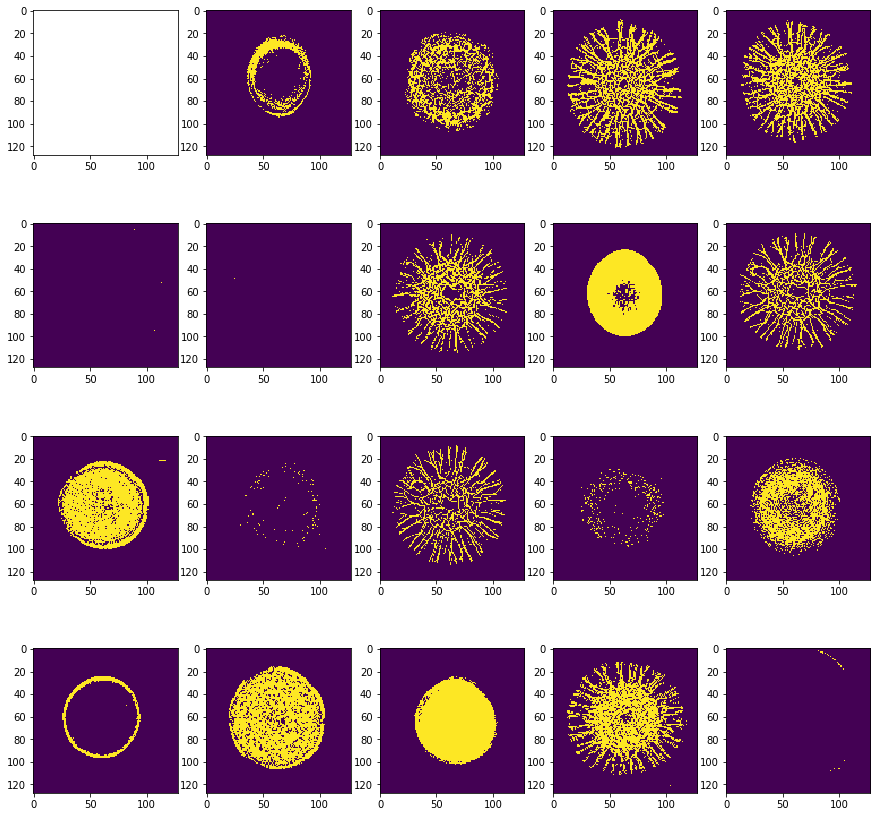

In [43]:
img_classes=[get_classes(img,threshold_val=0, resize=128, n_clusters=2)[1] for img in images]

f, axarr = plt.subplots(4, 5,figsize=(15,15))
k=0
for i in range(4):
    for j in range(5):
        axarr[i,j].imshow(img_classes[k])
        k+=1
        
plt.savefig('wrinkle_class_multiple.png')

### Plot wrinkle class using get_wrinkle_class¶


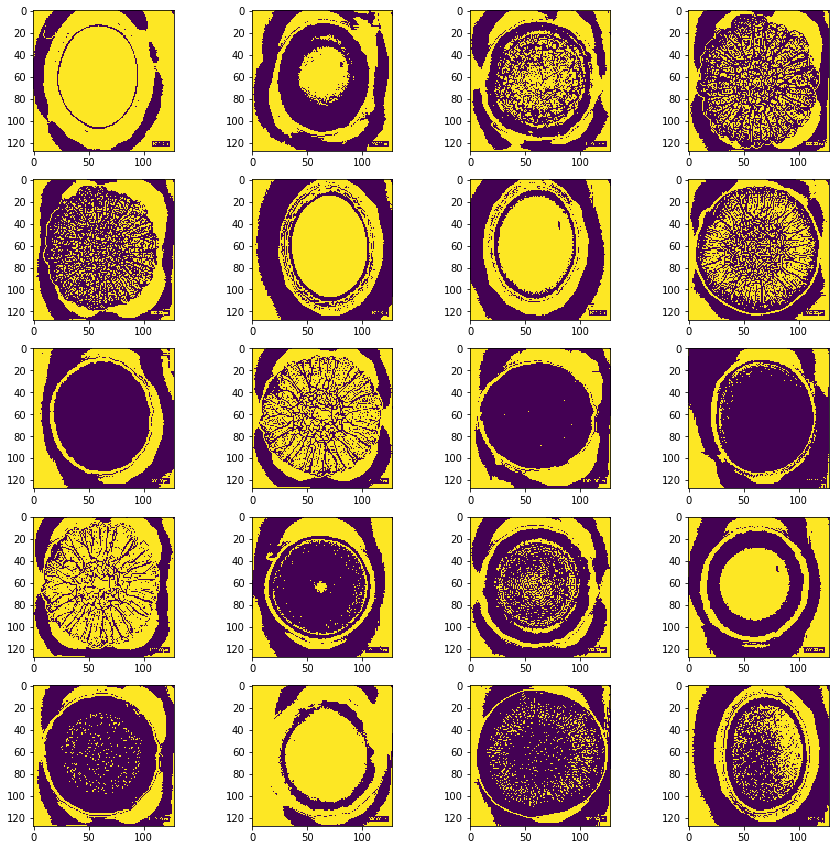

In [83]:
img_wrinkle_class=[get_wrinkle_class(img,threshold_val=100, resize=300, n_clusters=2)[1] for img in images]
f, axarr = plt.subplots(5,4,figsize=(15,15))
k=0
for i in range(5):
    for j in range(4):
        axarr[i,j].imshow(img_wrinkle_class[k])
        k+=1

In [ ]:
### Plot in polar coordinates

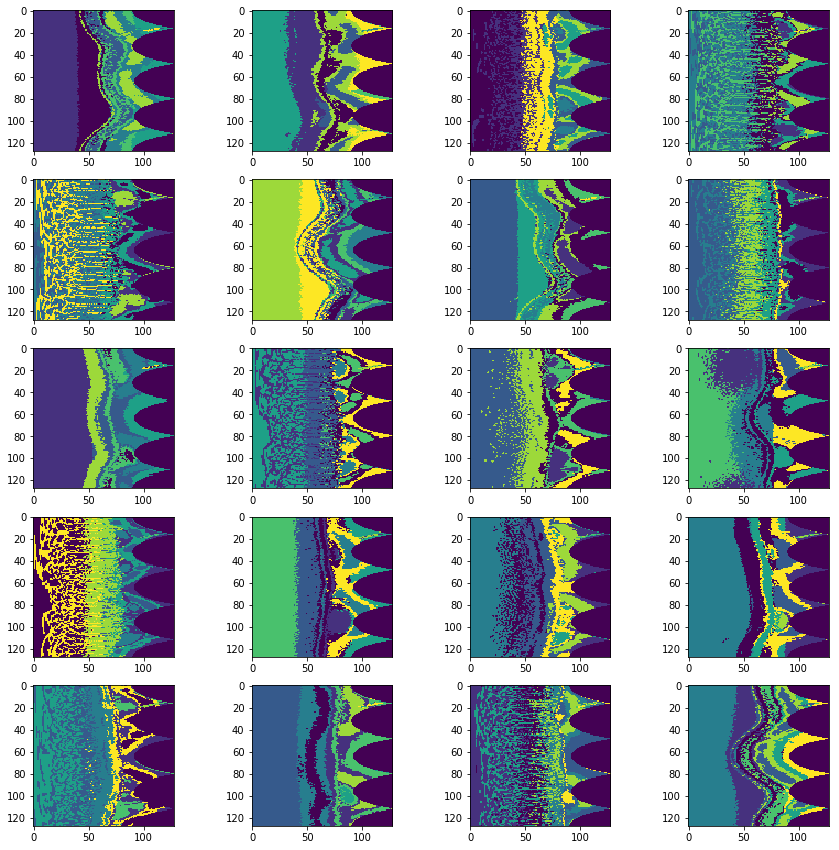

In [299]:
polar_images = [polar_coord(np.asarray(img)) for img in img_classes]
f, axarr = plt.subplots(5,4,figsize=(15,15))
k=0
for i in range(5):
    for j in range(4):
        axarr[i,j].imshow(polar_images[k])
        k+=1


(128, 128)

In [79]:
what = []
for img in polar_images:
    label  = np.reshape(img, (128*128, 1))
    x_axis = np.reshape(np.repeat(np.arange(128), 128), (128*128, 1))
    y_axis = np.array([])
    for i in np.arange(128):
        y_axis = np.append(y_axis, np.arange(128))

    y_axis = np.reshape(y_axis, (128 * 128, 1))
    X      = np.hstack((label, y_axis))
    km     = KMeans(n_clusters=4, random_state=0).fit(X)
    new_img = np.reshape(km.labels_, (128, 128))
    what += [new_img]

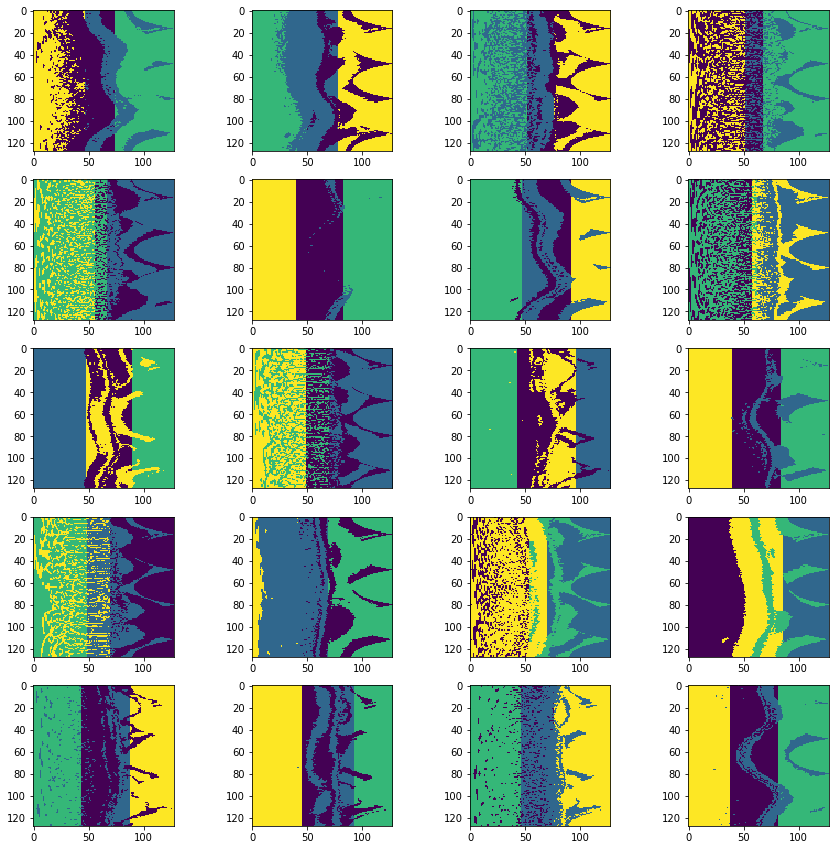

In [80]:
f, axarr = plt.subplots(5,4,figsize=(15,15))
k=0
for i in range(5):
    for j in range(4):
        axarr[i,j].imshow(what[k])
        k+=1


In [64]:
y_axis.shape

(16384, 1)

In [48]:
128*128*2

32768

In [5]:
img = np.array(img)
X   = np.reshape(img, (-1, 3))
print(img.shape)
print(X.shape)

(128, 128, 3)
(16384, 3)


## Plot colors (doesn't work)

In [39]:
img = images[2]
resize=128

img = Image.fromarray(img, 'RGB')
size=(resize, resize)
img_resize       = img.resize(size, Image.ANTIALIAS)#resize
img_array_resize = np.asarray(img_resize)


# Reshape
w,h,d = tuple(img_array_resize.shape)
X     = np.reshape(img_array_resize, (w*h,d))

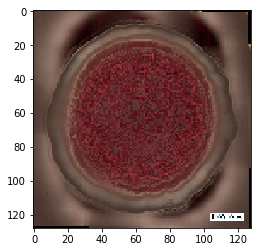

In [40]:
plt.imshow(images[2])

In [41]:
trace1 = go.Scatter3d(
    x=X[:, 0],
    y=X[:, 1],
    z=X[:, 2],
    mode='markers',
    marker=dict(
#         size=(np.arange(92)[::-1] * 45 / 92 + 5),
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=(go.Scene(
        xaxis=go.XAxis(title='Red'),
        yaxis=go.YAxis(title='Green'),
        zaxis=go.ZAxis(title='Blue')))

)
fig = go.Figure(data=data, layout=layout)

iplot(fig)

/home/isaac/anaconda2/envs/tf/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:531: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


/home/isaac/anaconda2/envs/tf/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:558: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


/home/isaac/anaconda2/envs/tf/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:582: DeprecationWarning:

plotly.graph_objs.ZAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.scene.ZAxis


/home/isaac/anaconda2/envs/tf/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:477: DeprecationWarning:

plotly.graph_obj

In [36]:
img.shape

AttributeError: 'Image' object has no attribute 'shape'

## KMeans

We then created the unsuprivised classiication techincich KMeans to its different colors. The red, green, and blue values were the features for each pixel, and the ouput what the class. We chose 7 classes based on visual inspection and manual testing. Futher analysis could invovle more quantitative determiation of K such as siloet score.

Figure X below shows the output of this model.

In [14]:

# This function takes as input an image, computes kmeans and outputs the labels and the image 'colored' by the classes.
def get_classes(img, resize=128, n_clusters=3, movie=False,threshold_val=50):
    
    """
    img: initial image

    returns: the labels of the pixels and the image colored by the classes
    """
    # convert into image if is array
    try:
        img = Image.fromarray(img, 'RGB')
    except:
        pass
    
    # keeps pixels above threshold
    img = threshold_image(img,threshold_val)
    
    # Resize
    if not movie:
        size=(resize, resize)
        img_resize       = img.resize(size, Image.ANTIALIAS)#resize
        img_array_resize = np.asarray(img_resize)
    else:
        reduce_factor    = 4
        size             = tuple(np.divide(img.shape[:2], reduce_factor).astype(int)) + (3,)
        img_array_resize = np.resize(img, size)

    
    # Reshape
    w,h,d = tuple(img_array_resize.shape)
    X     = np.reshape(img_array_resize, (w*h,d))

    # Add position variables
    y_axis = np.array([])
    for i in np.arange(128):
        y_axis = np.append(y_axis, np.arange(128))

    y_axis = np.reshape(y_axis, (128 * 128, 1))
    x_axis = np.reshape(np.repeat(np.arange(128), 128), (128*128, 1))
    X      = np.append(X, x_axis, axis=1)
    X      = np.append(X, y_axis, axis=1)

    return X


In [20]:
X = get_classes(images[0],threshold_val=100,n_clusters=3)

In [21]:
km = KMeans(n_clusters=7, random_state=0)
km.fit(X)
print(km.cluster_centers_.shape)
print(km.labels_.shape)


(7, 5)
(16384,)


In [85]:
def plot_classes(labels, shape):
    classes = np.reshape(labels, shape) 
    classes = np.multiply(classes, 255.0/np.max(classes)) #Nomalize
    # classes = np.reshape(np.array([classes, classes, classes]), (1695, 1776, 3))
    plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
    imgplot = plt.imshow(classes)
    plt.show()


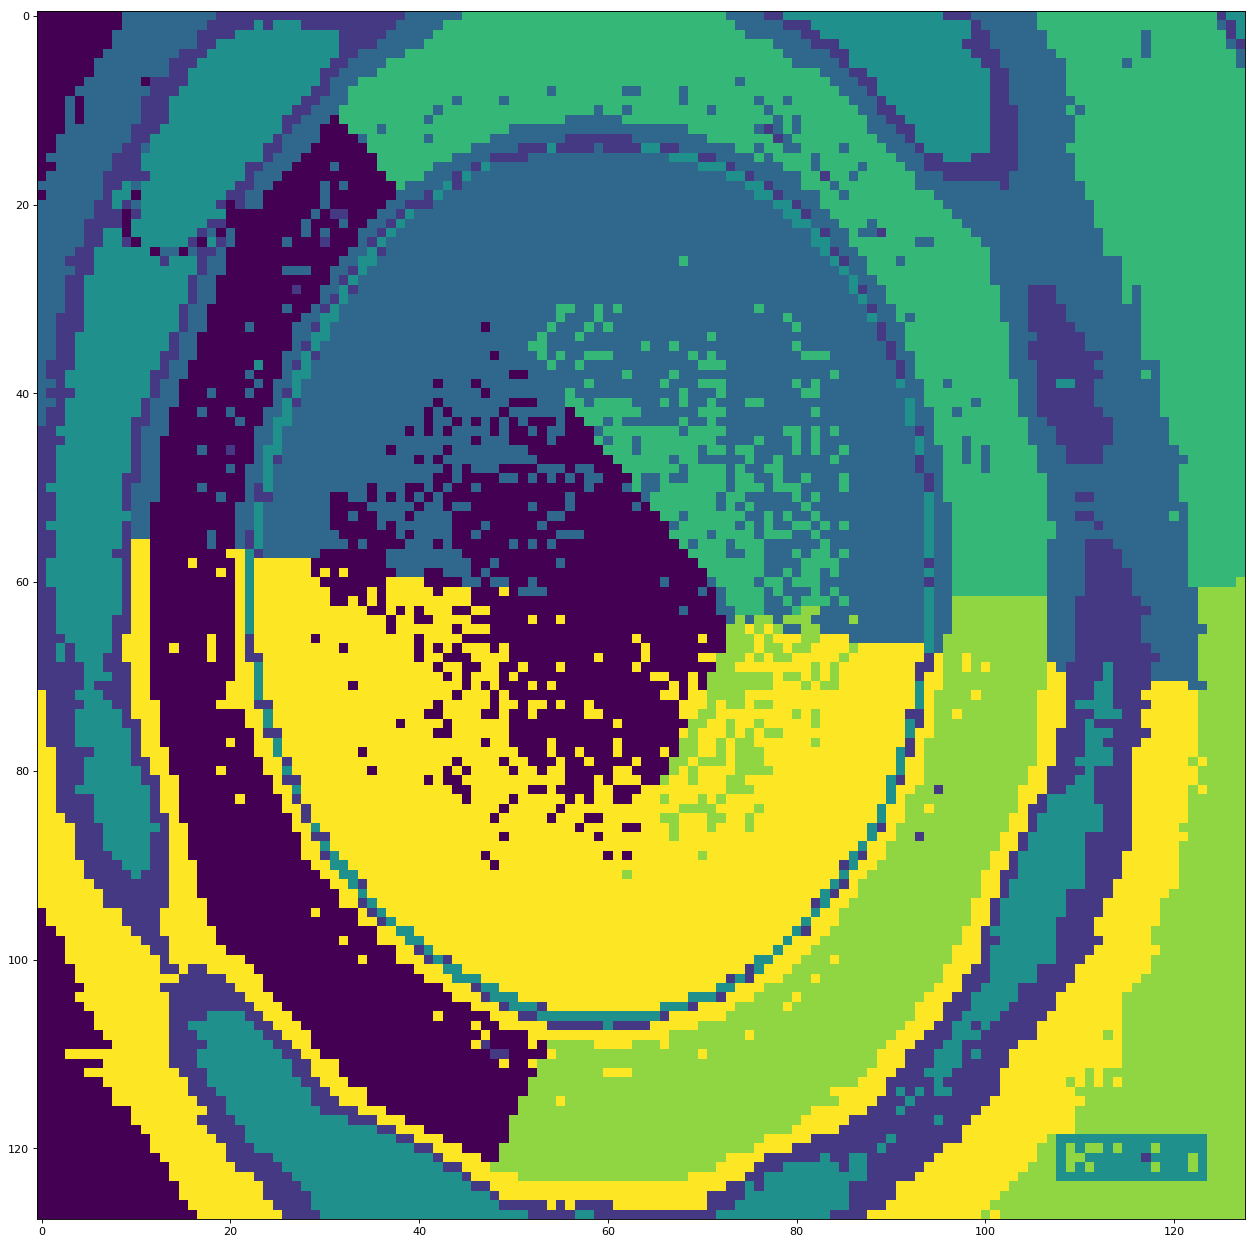

In [25]:
plot_classes(km.labels_, shape=images[0].shape[:2])

KMeans was chosen as a simple way to start, yet based on the uniquch nature of the wrinkles we though DBSCAN or Agglormortive clustering would provide better results. Figure X and Figure X show the results of DBSCAN and Agglomtorive clustering after multiple iterations of parameteds. So far the KMeans has performed best. This was another friendly reminder that more complex is not always better.

## DBSCAN

[-1  0  1  2  3]


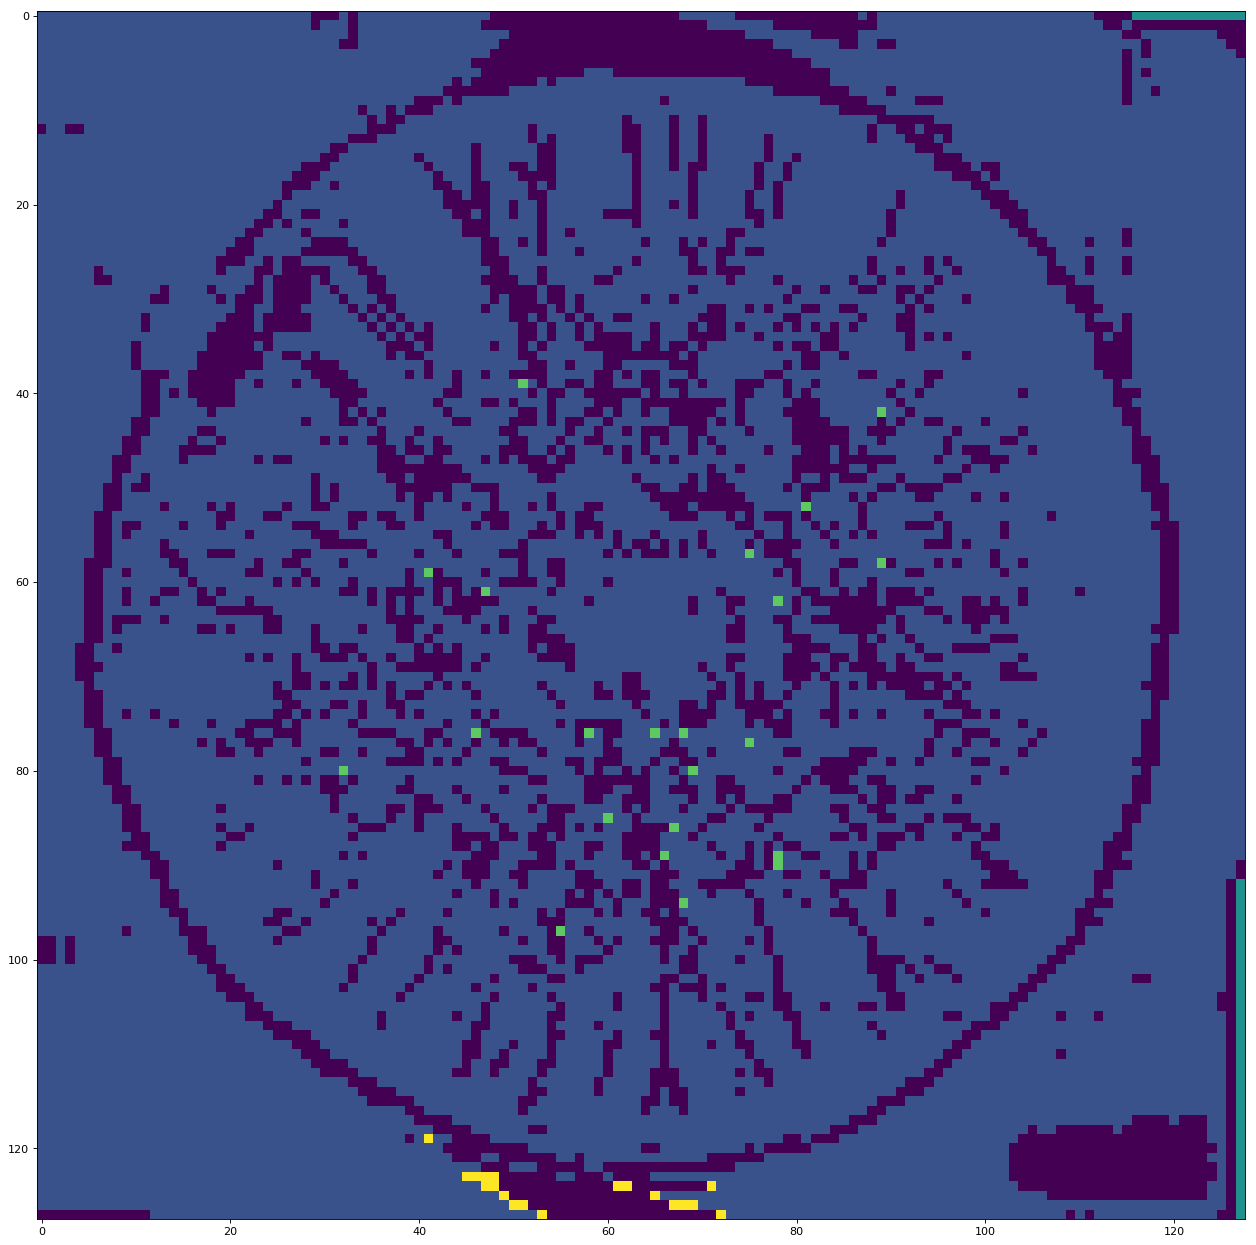

In [15]:
db = DBSCAN(eps=2, min_samples=30) #eps=10, min_samples=30
db.fit(X)
print(np.unique(db.labels_))
plot_classes(db.labels_, shape=img.shape[:2])

## Agglomertive clustering

In [88]:
ag = AgglomerativeClustering(n_clusters=6)
ag.fit(images[0])
plot_classes(ag.labels_, shape=img.shape[:2])

ValueError: Found array with dim 3. AgglomerativeClustering expected <= 2.

## Find wrinkle class

The most red color
The most center color
Plot wrinkle class white and everything else white

In [22]:
# Covert to data frame
df = pd.DataFrame(X, columns=['red', 'green', 'blue'])
df.head()

,red,green,blue
0,85,63,52
1,84,62,51
2,82,60,49
3,81,59,48
4,81,59,48


In [23]:
df_mean = df.astype('int').groupby(km.labels_).mean()
df_mean

,red,green,blue
0,91.912262,34.871341,37.313968
1,133.318340,103.535066,92.666723
2,124.052962,51.685593,56.886611
3,109.563848,77.948375,70.315987
4,251.458662,252.280363,250.050670
5,92.460525,59.672196,54.635340
6,46.904138,23.062640,20.452480


In [24]:
df_mean

,red,green,blue
0,91.912262,34.871341,37.313968
1,133.318340,103.535066,92.666723
2,124.052962,51.685593,56.886611
3,109.563848,77.948375,70.315987
4,251.458662,252.280363,250.050670
5,92.460525,59.672196,54.635340
6,46.904138,23.062640,20.452480


In [39]:
# Find most red class
df_mean['red_diff'] = (np.divide(df_mean['red'], df_mean['green']) +  
                       np.divide(df_mean['red'], df_mean['blue'])) / 2.0

wrinkle_id     = 0#np.argmax(df_mean['red_diff'])
wrinkle_labels = [1 if i == wrinkle_id else 0 for i in km.labels_]

Next we wanted to indentify the wrinkle class in a programatic way. We noticed this was the most red class and therfore found the larges ration between red/green and red/blue to identify the wrinkle class. The result is in Figure X. With this base anlaysis we can simply count the number of pixes to determine percent wrinkle. Yet we can also use this as the basis for much more feature detection.


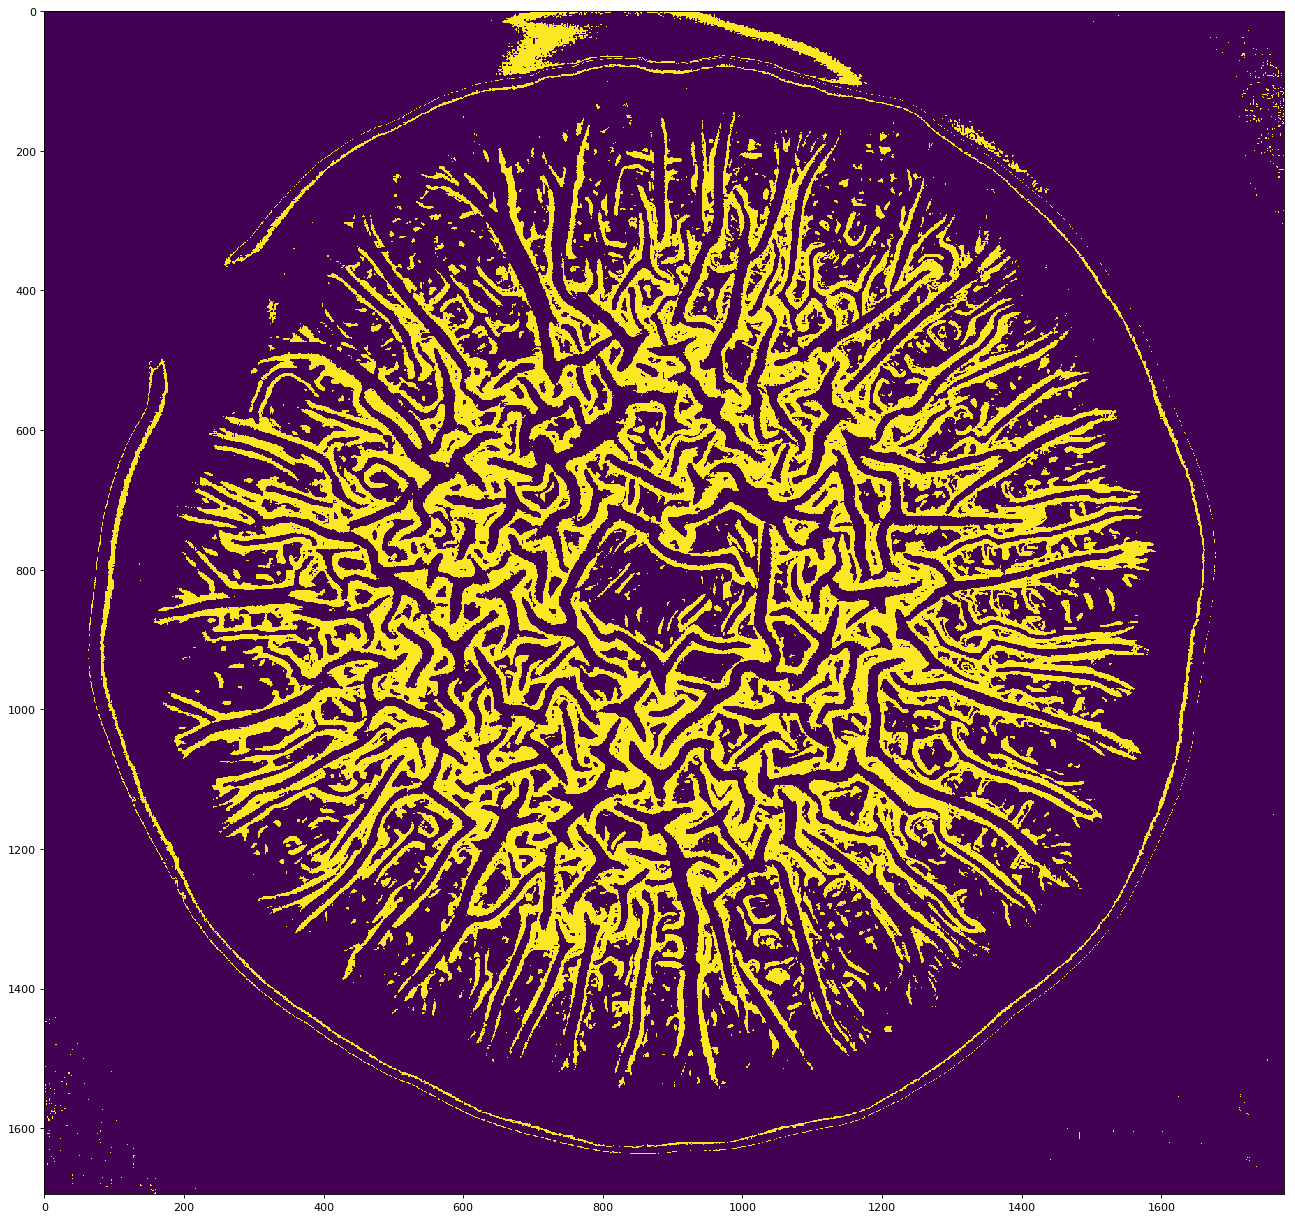

In [40]:
plot_classes(wrinkle_labels, shape=img.shape[:2])

## Remove outter border

Find circle class by finding class with lowest stdev of distence from the center

In [144]:
# Get coordinate position
df['class']   = km.labels_
df['x_coord'] = np.asarray(df.index / 128.0 , dtype=int)
y_coord = np.array([])
for i in np.arange(128):
    y_coord = np.append(y_coord, np.arange(128))

df['y_coord'] = y_coord


In [152]:
# Calculate distance from center
df['dist_from_center'] = np.sqrt(np.abs(df['x_coord'] - 64)**2 + np.abs(df['y_coord'] - 64)**2)

In [175]:
boundry_order = np.argsort(df.groupby(['class']).std()['dist_from_center'])
# df.groupby(['class']).std()['dist_from_center']
boundry_order
np.argmax(df.groupby(['class']).std()['dist_from_center'])

/home/isaac/anaconda2/envs/tf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning:

'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.



1

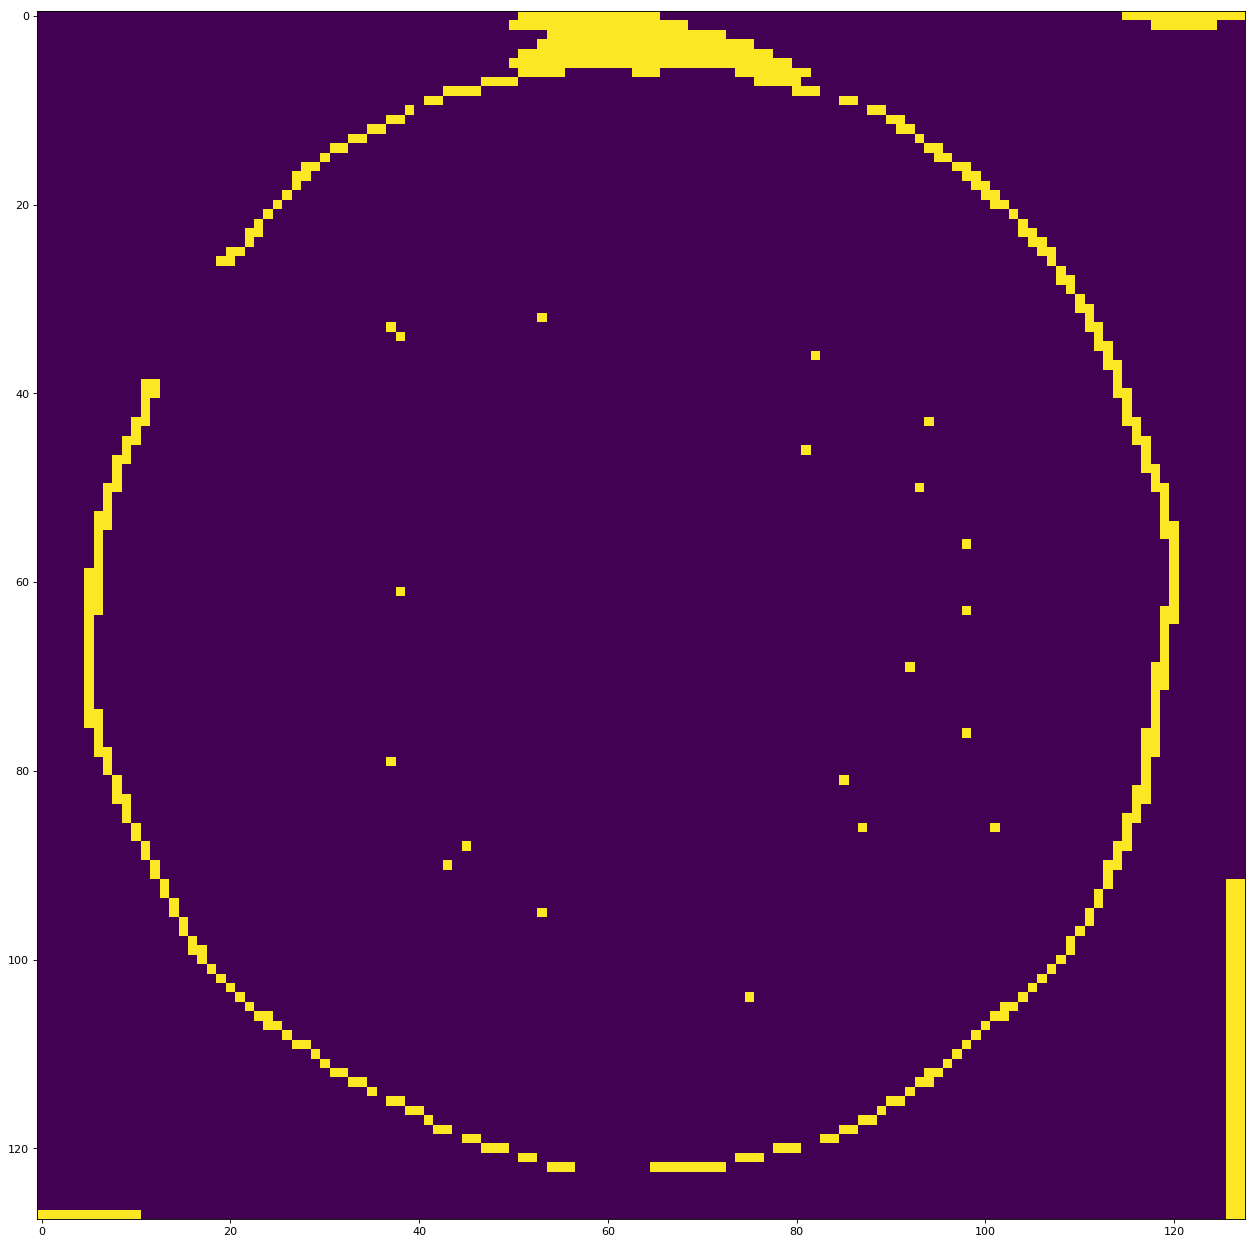

In [180]:
boundry_id     = 6 #np.argmax(df.groupby(['class']).std()['dist_from_center']) # Need to fix this
boundry_labels = [1 if i == boundry_id else 0 for i in km.labels_]
plot_classes(boundry_labels, shape=img.shape[:2])
